In [11]:
import torch
import numpy as np
import triton
import triton.language as tl
import matplotlib
import pandas as pd


In [12]:
# We can fuse `leaky_relu` by providing it as an `ACTIVATION` meta-parameter in `_matmul`.
@triton.jit
def leaky_relu(x):
    # x = x + 1
    return tl.where(x >= 0, x, 0.01 * x)


In [13]:
# `triton.jit`'ed functions can be auto-tuned by using the `triton.autotune` decorator, which consumes:
#   - A list of `triton.Config` objects that define different configurations of
#       meta-parameters (e.g., `BLOCK_SIZE_M`) and compilation options (e.g., `num_warps`) to try
#   - An auto-tuning *key* whose change in values will trigger evaluation of all the
#       provided configs
@triton.autotune(
    configs=[
        triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 64, 'GROUP_SIZE_M': 8}, num_stages=3, num_warps=8),
        triton.Config({'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=5, num_warps=2),
        triton.Config({'BLOCK_SIZE_M': 32, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=5, num_warps=2),
    ],
    key=['M', 'N', 'K'],
    reset_to_zero=['d_ptr'],
)
@triton.jit
def matmul_kernel(
    # Pointers to matrices
    a_ptr, b_ptr, c_ptr, d_ptr,
    # Matrix dimensions
    M, N, K,
    # The stride variables represent how much to increase the ptr by when moving by 1
    # element in a particular dimension. E.g. `stride_am` is how much to increase `a_ptr`
    # by to get the element one row down (A has M rows).
    stride_am, stride_ak,
    stride_bk, stride_bn,
    stride_cn, stride_ck,
    stride_dm, stride_dk,
    # Meta-parameters
    BLOCK_SIZE_M: tl.constexpr, BLOCK_SIZE_N: tl.constexpr, BLOCK_SIZE_K: tl.constexpr,
    GROUP_SIZE_M: tl.constexpr,
    ACTIVATION: tl.constexpr,
):
    """Kernel for computing the matmul C = A x B.
    A has shape (M, K), B has shape (K, N) and C has shape (M, N)
    """
    # -----------------------------------------------------------
    # Map program ids `pid` to the block of C it should compute.
    # This is done in a grouped ordering to promote L2 data reuse.
    # See above `L2 Cache Optimizations` section for details.
    pid = tl.program_id(axis=0)
    num_pid_m = tl.cdiv(M, BLOCK_SIZE_M)
    num_pid_n = tl.cdiv(N, BLOCK_SIZE_N)
    num_pid_in_group = GROUP_SIZE_M * num_pid_n
    group_id = pid // num_pid_in_group
    first_pid_m = group_id * GROUP_SIZE_M
    group_size_m = min(num_pid_m - first_pid_m, GROUP_SIZE_M)
    pid_m = first_pid_m + (pid % group_size_m)
    pid_n = (pid % num_pid_in_group) // group_size_m

    TYPE = a_ptr.type.element_ty

    # ----------------------------------------------------------
    # Create pointers for the first blocks of A and B.
    # We will advance this pointer as we move in the K direction
    # and accumulate
    # `a_ptrs` is a block of [BLOCK_SIZE_M, BLOCK_SIZE_K] pointers
    # `b_ptrs` is a block of [BLOCK_SIZE_K, BLOCK_SIZE_N] pointers
    # See above `Pointer Arithmetics` section for details
    offs_am = (pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)) % M
    offs_bn = (pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)) % N
    offs_k = tl.arange(0, BLOCK_SIZE_K)
    a_ptrs = a_ptr + (offs_am[:, None] * stride_am + offs_k[None, :] * stride_ak)
    b_ptrs = b_ptr + (offs_k[:, None] * stride_bk + offs_bn[None, :] * stride_bn)

    # -----------------------------------------------------------
    # Iterate to compute a block of the C matrix.
    # We accumulate into a `[BLOCK_SIZE_M, BLOCK_SIZE_N]` block
    # of fp32 values for higher accuracy.
    # `accumulator` will be converted back to fp16 after the loop.
    accumulator = tl.zeros((BLOCK_SIZE_M, BLOCK_SIZE_N), dtype=tl.float32)
    for k in range(0, tl.cdiv(K, BLOCK_SIZE_K)):
        # Load the next block of A and B, generate a mask by checking the K dimension.
        # If it is out of bounds, set it to 0.
        a = tl.load(a_ptrs, mask=offs_k[None, :] < K - k * BLOCK_SIZE_K, other=0.0)
        b = tl.load(b_ptrs, mask=offs_k[:, None] < K - k * BLOCK_SIZE_K, other=0.0)
        # We accumulate along the K dimension.
        accumulator += tl.dot(a, b)
        # Advance the ptrs to the next K block.
        a_ptrs += BLOCK_SIZE_K * stride_ak
        b_ptrs += BLOCK_SIZE_K * stride_bk

    accumulator = accumulator.to(TYPE)
    if ACTIVATION == "leaky_relu":
        accumulator = leaky_relu(accumulator).to(TYPE)

    offs_cn = pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)
    offs_dm = pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)
    c_ptrs = c_ptr + (offs_cn[:, None] * stride_cn + offs_k[None, :] * stride_ck)
    d_ptrs = d_ptr + (offs_dm[:, None] * stride_dm + offs_k[None, :] * stride_dk)
    for k in range(0, tl.cdiv(K, BLOCK_SIZE_K)):
        # c = C[n : n+BLOCK_SIZE_N, k : k+BLOCK_SIZE_K]
        #c = tl.load(c_ptrs, mask=offs_k[None, :] < K - k * BLOCK_SIZE_K, other=0.0)
        c = tl.load(c_ptrs)
        # M x N @ N x K
        accumulator2 = tl.dot(accumulator, c)

        accumulator2 = accumulator2.to(TYPE)
        # D[m : m+BLOCK_SIZE_M, k : k+BLOCK_SIZE_K] += acc2
        #tl.atomic_add(d_ptrs, accumulator2, mask=offs_k[:, None] < K - k * BLOCK_SIZE_K)
        tl.atomic_add(d_ptrs, accumulator2)

        # Advance the ptrs to the next K block.
        c_ptrs += BLOCK_SIZE_K * stride_ck
        d_ptrs += BLOCK_SIZE_K * stride_dk



In [14]:
def mlp_triton(A, B, C, ACTIVATION=None):
    # Check constraints.
    assert A.shape[1] == B.shape[0], "Incompatible dimensions"
    assert B.shape[1] == C.shape[0], "Incompatible dimensions"
    assert A.shape[1] == C.shape[1], "Incompatible dimensions"
    assert A.is_contiguous(), "Matrix A must be contiguous"
    assert B.is_contiguous(), "Matrix B must be contiguous"
    assert C.is_contiguous(), "Matrix C must be contiguous"
    M, K = A.shape
    K, N = B.shape
    #N, K = C.shape
    # Allocates output.
    # C = torch.empty((M, N), device=A.device, dtype=A.dtype)
    D = torch.zeros((M, K), device=A.device, dtype=A.dtype)

    # 1D launch kernel where each block gets its own program.
    grid = lambda META: (
        triton.cdiv(M, META['BLOCK_SIZE_M']) * triton.cdiv(N, META['BLOCK_SIZE_N']),
    )

    matmul_kernel[grid](
        A, B, C, D,
        M, N, K,
        A.stride(0), A.stride(1),
        B.stride(0), B.stride(1),
        C.stride(0), C.stride(1),
        D.stride(0), D.stride(1),
        ACTIVATION=ACTIVATION,
    )

    return D

In [15]:
def mlp_torch(A, B, C, ACTIVATION=None):
    if ACTIVATION == "leaky_relu":
        return torch.matmul(torch.nn.functional.leaky_relu(torch.matmul(A, B)), C)
    else:
        return torch.matmul(torch.matmul(A, B), C)


In [17]:
def unit_test():
    bsz = 16
    size = 256
    dtype = torch.float16
    torch.manual_seed(131)
    A = torch.randn((bsz, size), device='cuda', dtype=dtype)
    B = torch.randn((size, size * 4), device='cuda', dtype=dtype)
    C = torch.randn((size * 4, size), device='cuda', dtype=dtype)

    triton_output = mlp_triton(A, B, C, ACTIVATION="leaky_relu")
    torch_output = mlp_torch(A, B, C, ACTIVATION="leaky_relu")
    print(f"triton_output={triton_output}")
    print(f"torch_output={torch_output}")
    if torch.allclose(triton_output, torch_output, atol=1.0, rtol=1e-2):
        print("✅ Triton and Torch match")
    else:
        print("❌ Triton and Torch differ")
        
    diff = np.abs(triton_output[0].cpu().numpy() - torch_output.cpu().numpy())
    print("max diff:",np.max(diff))
    print("mean diff:",np.mean(diff))

unit_test()

triton_output=tensor([[-400.2500,  500.0000,  156.5000,  ...,   45.3750,  459.0000,
         -866.0000],
        [  33.8750,  173.3750,  -35.3750,  ...,  492.7500, -115.3750,
           44.8750],
        [-493.0000,  -19.8125, -230.0000,  ...,  148.1250,  342.5000,
         -113.0000],
        ...,
        [ -11.2031,  770.0000,  274.5000,  ...,  105.0625,   27.2812,
           88.5000],
        [ -56.5312,  242.0000, -128.0000,  ...,  294.5000, -402.5000,
         -304.0000],
        [-379.7500,   93.5000, -635.5000,  ...,  -97.3750, -385.5000,
         -172.7500]], device='cuda:0', dtype=torch.float16)
torch_output=tensor([[-400.0000,  500.0000,  156.5000,  ...,   45.5938,  459.0000,
         -866.0000],
        [  33.7500,  173.3750,  -35.2812,  ...,  492.5000, -115.5000,
           45.2188],
        [-493.5000,  -19.7031, -229.7500,  ...,  148.2500,  342.2500,
         -113.0625],
        ...,
        [ -11.2656,  770.0000,  274.2500,  ...,  104.8125,   27.0469,
           88.5000]

In [18]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['N'],  # Argument names to use as an x-axis for the plot
        x_vals=[
            # 2 ** i for i in range(5, 14)
            256 * i for i in range(2, 16)
        ],  # Different possible values for `x_name`
        line_arg='provider',  # Argument name whose value corresponds to a different line in the plot
        # Possible values for `line_arg`
        line_vals=['torch', 'triton'],
        # Label name for the lines
        line_names=["Torch", "Triton"],
        # Line styles
        styles=[('green', '-'), ('blue', '-')],
        ylabel="TFLOPS",  # Label name for the y-axis
        plot_name="mlp-performance",  # Name for the plot, used also as a file name for saving the plot.
        args={},
    )
)
def benchmark(N, provider):
    dtype = torch.float16
    bsz = N//4
    size = N
    torch.manual_seed(1321)
    A = torch.randn((bsz, size), device='cuda', dtype=dtype)
    B = torch.randn((size, size * 4), device='cuda', dtype=dtype)
    C = torch.randn((size * 4, size), device='cuda', dtype=dtype)
    quantiles = [0.5, 0.2, 0.8]
    if provider.startswith('torch'):
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: mlp_torch(A, B, C, ACTIVATION="leaky_relu"), quantiles=quantiles)
    if provider.startswith('triton'):
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: mlp_triton(A, B, C, ACTIVATION="leaky_relu"), quantiles=quantiles)
    perf = lambda ms: 4 * bsz * size * size * 4 * 1e-12 / (ms * 1e-3)
    return perf(ms), perf(max_ms), perf(min_ms)


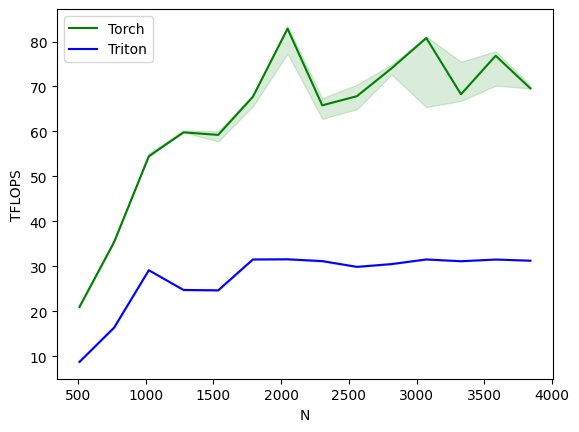

mlp-performance:
         N      Torch     Triton
0    512.0  20.971521   8.738134
1    768.0  35.389441  16.384000
2   1024.0  54.471483  29.127110
3   1280.0  59.795622  24.749246
4   1536.0  59.229188  24.661630
5   1792.0  67.707374  31.527135
6   2048.0  82.850450  31.565789
7   2304.0  65.806810  31.164868
8   2560.0  67.842649  29.884178
9   2816.0  74.047891  30.503614
10  3072.0  80.774758  31.528711
11  3328.0  68.270551  31.138105
12  3584.0  76.834352  31.510564
13  3840.0  69.576597  31.253921


In [8]:
benchmark.run(show_plots=True, print_data=True)
